In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("task1_data.txt")
train_labels = pd.read_csv("task1_train_label.txt", header=None, sep="\t", names=["order", "label"])
valid_labels = pd.read_csv("task1_valid_label.txt", header=None, sep="\t", names=["order", "label"])
test_query = pd.read_csv("task1_test_query.txt",header=None, names=["order"])

In [3]:
train_df_original = df.merge(train_labels, on="order")
valid_df_original = df.merge(valid_labels, on="order")
test_df_original = df.merge(test_query, on="order")

In [ ]:
train_df = train_df_original.copy()
valid_df = valid_df_original.copy()
test_df = test_df_original.copy()

In [4]:
train_df["label"].value_counts(dropna=False)

label
1    1116464
0     431381
2     345549
Name: count, dtype: int64

# Baseline

In [5]:
def create_return_df(df, labels, product_stats):
    df = df.merge(product_stats["return_rate"], how='left', right_index=True, left_on='product')
    df["no_return_rate"] = 1 - df["return_rate"]
    order_return_rate = df.groupby('order')['return_rate'].prod()
    order_no_return_rate = df.groupby('order')['no_return_rate'].prod()
    return_df = pd.concat([order_return_rate, order_no_return_rate], axis=1, keys=['order_return_rate', 'order_no_return_rate'])
    return_df["some_return"] = 1 - return_df["order_no_return_rate"] - return_df["order_return_rate"]
    return_df = return_df.merge(labels, on="order")
    return return_df

<Axes: >

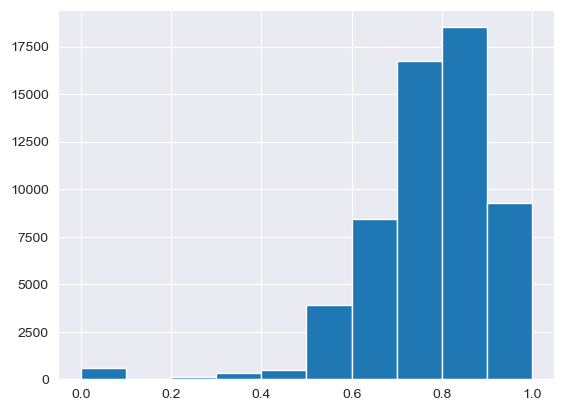

In [6]:
# Calculate how many times each product has been in an order that was returned/partially returned
# Return probability is the ratio of returns/partial returns and all occurences of the product
product_stats = train_df.groupby('product').agg(
    total_count=('product', 'count'),
    return_1_or_2_count=('label', lambda x: (x==1).sum() + (x==2).sum())
).reset_index(drop=True)
product_stats['return_rate'] = product_stats['return_1_or_2_count'] / product_stats['total_count']
product_stats["return_rate"].hist()

In [10]:
import numpy as np

valid_return_df = create_return_df(valid_df, valid_labels, product_stats) # Prediction is the highest of the three probabilities
conditions = [
    (valid_return_df['order_no_return_rate'] > valid_return_df['some_return']) & (valid_return_df['order_no_return_rate'] > valid_return_df['order_return_rate']),
    (valid_return_df['some_return'] > valid_return_df['order_no_return_rate']) & (valid_return_df['some_return'] > valid_return_df['order_return_rate']),
    (valid_return_df['order_return_rate'] > valid_return_df['order_no_return_rate']) & (valid_return_df['order_return_rate'] > valid_return_df['some_return'])
]

choices = [0, 1, 2]

valid_return_df['prediction'] = np.select(conditions, choices, default=np.nan)

In [12]:
# Accuracy calculation
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

0.4503717311602566

# Baseline - Simple model

In [13]:
train_return_df = create_return_df(train_df, train_labels, product_stats)
valid_return_df = create_return_df(valid_df, valid_labels, product_stats)

In [14]:
from sklearn.linear_model import SGDClassifier
feature_names = ["order_return_rate", "order_no_return_rate", "some_return"]
features = train_return_df[feature_names]
labels = train_return_df["label"]
model = SGDClassifier()
model.fit(features, labels)
score = model.score(features, labels)

score

0.6040559864071463

In [15]:
valid_return_df["prediction"] = model.predict(valid_return_df[feature_names])
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

0.579508074456142

# Use user return rate

In [16]:
# Create user return stats
customer_stats = train_df.groupby('customer').agg(
    total_count=('customer', 'count'),
    partial_return=('label', lambda x: (x==1).sum()),
    total_return = ('label', lambda x: (x==2).sum()),
).reset_index(drop=True)
customer_stats["no_return"] = customer_stats["total_count"] - customer_stats["partial_return"] - customer_stats["total_return"]

customer_stats["partial_return_rate"] = customer_stats["partial_return"] / customer_stats["total_count"]
customer_stats["total_return_rate"] = customer_stats["total_return"] / customer_stats["total_count"]
customer_stats["no_return_rate"] = customer_stats["no_return"] / customer_stats["total_count"]

In [ ]:
# Merge stats on the return dataframes
train_order_customer = train_df.groupby('order')['customer'].first().reset_index()
valid_order_customer = valid_df.groupby('order')['customer'].first().reset_index()

train_return_df = train_return_df.merge(train_order_customer, on="order")
train_return_df = train_return_df.merge(customer_stats[["no_return_rate", "partial_return_rate", "total_return_rate"]].add_prefix("customer_"), left_on="customer", right_index=True)

valid_return_df = valid_return_df.merge(valid_order_customer, on="order")
valid_return_df = valid_return_df.merge(customer_stats[["no_return_rate", "partial_return_rate", "total_return_rate"]].add_prefix("customer_"), left_on="customer", right_index=True)

In [ ]:
from sklearn.linear_model import SGDClassifier
feature_names = ["order_return_rate", "order_no_return_rate", "some_return", "customer_no_return_rate", "customer_partial_return_rate", "customer_total_return_rate"]
features = train_return_df[feature_names]
labels = train_return_df["label"]
model = SGDClassifier()
model.fit(features, labels)
score = model.score(features, labels)
score

In [ ]:
valid_return_df["prediction"] = model.predict(valid_return_df[feature_names])
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

# Use item group info

In [ ]:
train_df

In [ ]:
train_counts = train_df.groupby(['order', 'group']).size()
valid_counts = valid_df.groupby(['order', 'group']).size()

In [ ]:
train_order_size = train_df.groupby('order').size()
valid_order_size = valid_df.groupby('order').size()

train_normalized_counts = train_counts / train_order_size.loc[train_counts.index.get_level_values('order')].values
valid_normalized_counts = valid_counts / valid_order_size.loc[valid_counts.index.get_level_values('order')].values

In [ ]:
train_normalized_counts

In [ ]:
train_normalized_pivot = train_normalized_counts.unstack(fill_value=0)
valid_normalized_pivot = valid_normalized_counts.unstack(fill_value=0)

In [ ]:
if len(valid_normalized_pivot.columns) != len(train_normalized_pivot.columns):
    missing_cols = set(train_normalized_pivot.columns) - set(valid_normalized_pivot.columns)
    valid_normalized_pivot[list(missing_cols)] = 0

In [ ]:
train_return_df = create_return_df(train_df, train_labels, product_stats)
valid_return_df = create_return_df(valid_df, valid_labels, product_stats)

In [ ]:
train_return_df

In [ ]:
train_return_df = train_return_df.merge(train_normalized_pivot.add_prefix("group_"), left_on='order', right_index=True)
valid_return_df = valid_return_df.merge(valid_normalized_pivot.add_prefix("group_"), left_on='order', right_index=True)

In [ ]:
train_return_df

In [ ]:
feature_names = ["order_return_rate", "order_no_return_rate", "some_return"] + [f"group_{i}" for i in range(32)]
features = train_return_df[feature_names]
labels = train_return_df["label"]
model = SGDClassifier()
model.fit(features, labels)
score = model.score(features, labels)
score

In [ ]:
valid_return_df["prediction"] = model.predict(valid_return_df[feature_names])
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

# Customer group size difference

In [ ]:
def create_user_stat(df, group_by_cols, agg_col, agg_func):
    suff = "_"+"_".join(group_by_cols) + "_stat"
    agg_col_stat = agg_col + suff
    
    customer_stat =  df.groupby(group_by_cols).agg({agg_col: agg_func})
    merged_df = df.merge(customer_stat, on=group_by_cols, suffixes=("",suff))
    return merged_df

usual_user_size_by_group = train_df.groupby(['customer', 'group']).agg({"size": lambda x: pd.Series.mode(x)})
train_df = df.merge(usual_user_size_by_group, on=['customer', 'group'], suffixes=("","_customer_group_stat"))

In [ ]:
train_df = create_user_stat(train_df, ["customer", "group"], "size", lambda x: pd.Series.mode(x))

In [ ]:
train_df["size_diff"] = train_df["size"] - train_df["size_customer_group_stat"]

In [ ]:
filter_single_mode = train_df[train_df["size_diff"].apply(lambda x: isinstance(x, np.int64))]
filter_multi_mode = train_df[train_df["size_diff"].apply(lambda x: not isinstance(x, np.int64))]

filter_multi_mode["size_diff"] = filter_multi_mode["size_diff"].apply(lambda x: min(abs(x)))

In [ ]:
train_df.update(filter_multi_mode)

In [ ]:
train_df.groupby("order")["size_diff"].sum()

In [ ]:
train_return_df = create_return_df(train_df, train_labels, product_stats)
valid_return_df = create_return_df(valid_df, valid_labels, product_stats)